In [1]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats 
import statsmodels.api as sm
import itertools
from matplotlib.pyplot import figure
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

# Зинькович Сергей Дмитриевич 
## М9120-09.04.01 иибд
## II Вариант

# 1) **Временные ряды**

In [2]:
data = [5400, 5630, 5420, 5680, 5400, 5620, 5410, 5700, 5590, 5700, 5680, 5700, 5600, 5680, 5400, 5570, 5410, 5500,
         5410, 5510, 5490, 5800, 5530, 5700, 5600, 5700, 5550, 5630, 5600, 5700, 5680, 5700, 5520, 5530, 5380, 5600,
         5580, 5700, 5620, 5730, 5680, 5800, 5540, 5640, 5610, 5720, 5610, 5700, 5900, 5990, 5900, 5930, 5940, 6300,
         5930, 6020, 6000, 6200, 6300, 6270]
data = np.array(data)

## 1) Построение графика временного ряда

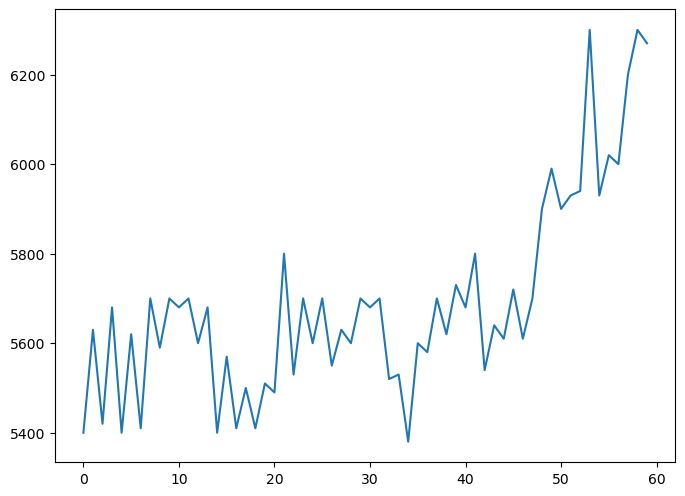

In [3]:
figure(figsize=(8, 6), dpi=100)
plt.plot(data)
pass

## 2) Построение автокорреляционной функции ACF и ее графика

Построение автокорреляционной функции ACF

Формула для вычисления автоковариационной функции на лаге k

$ s_k = \frac{1}{n}\sum^{n-k}_{i=1} (y_i - \bar y) (y_{i+k} - \bar y) = \frac{1}{n} \sum^n_{i=k+1} (y_i - \bar y) (y_{i-k} - \bar y) $

В этом случае автокорреляционная функция принимает вид

$ r_k = \frac{s_k}{s_0} $

In [4]:
s = []
for i in range(len(data) // 2):
    t1 = data[:len(data) - i]
    t2 = data[i:]
    s.append(((t1 - data.mean()) * (t2 - data.mean())).sum() / len(data))
s /= s[0]
', '.join(['%.5f' % i for i in s])

'1.00000, 0.66627, 0.69805, 0.44189, 0.55123, 0.36167, 0.40944, 0.18532, 0.30756, 0.16850, 0.24151, 0.05966, 0.14707, 0.01519, 0.12705, -0.02161, 0.09221, -0.01403, 0.10584, -0.06403, 0.02480, -0.13171, -0.04047, -0.15254, -0.08633, -0.15819, -0.03535, -0.05911, 0.04800, -0.05728'

Построение графика автокорреляционной функции ACF

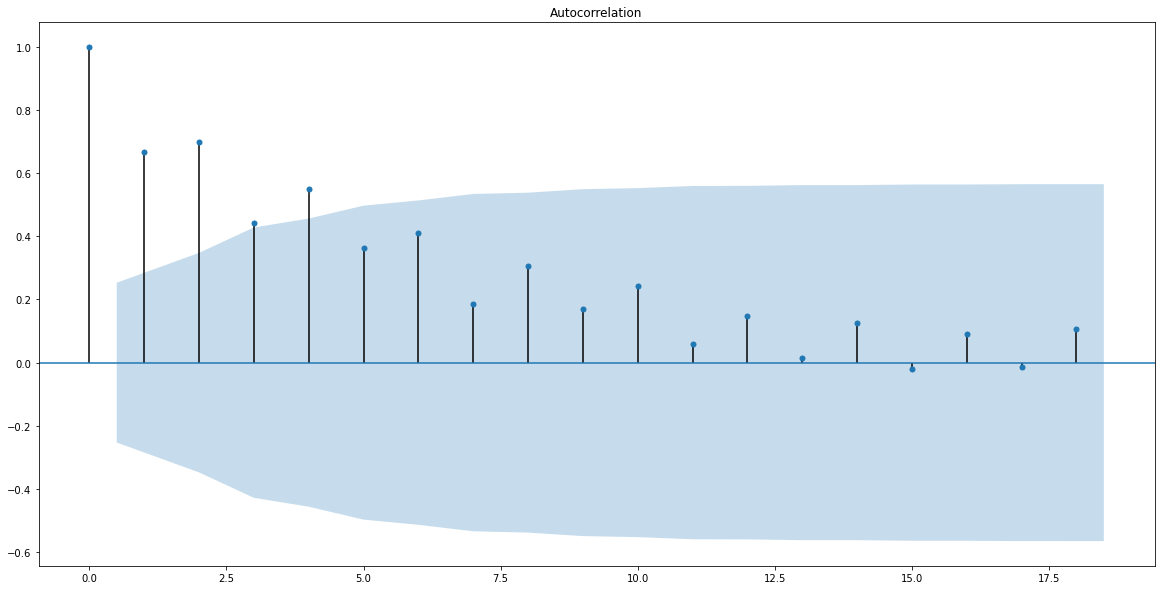

In [5]:
plt.rcParams["figure.figsize"] = (20,10)
plot_acf(data, )
pass

## 3) Проверка временного ряда на стационарность

Вид графика ACF характерен для нестационарных рядов, так как он плавно сходится к 0. Чтобы убедится в этом, проверим ряд на стационарность с помощью теста Дики — Фуллера

In [6]:
adfuller(data)

(2.5564427308401494,
 0.9990658199020468,
 7,
 52,
 {'1%': -3.562878534649522,
  '5%': -2.918973284023669,
  '10%': -2.597393446745562},
 580.9209964354222)

ADF статистика больше, чем все приведенные критические значения, а также p-value велико. Можно утверждать, что ряд не стационарен.

## 4) Построение аддитивной модели ряда

Магнитуда полученного ряда не возрастает, и, по его виду можно сказать, что он описывается аддитивной моделью. Разложим исходный ряд в соответствии с выбранной моделью

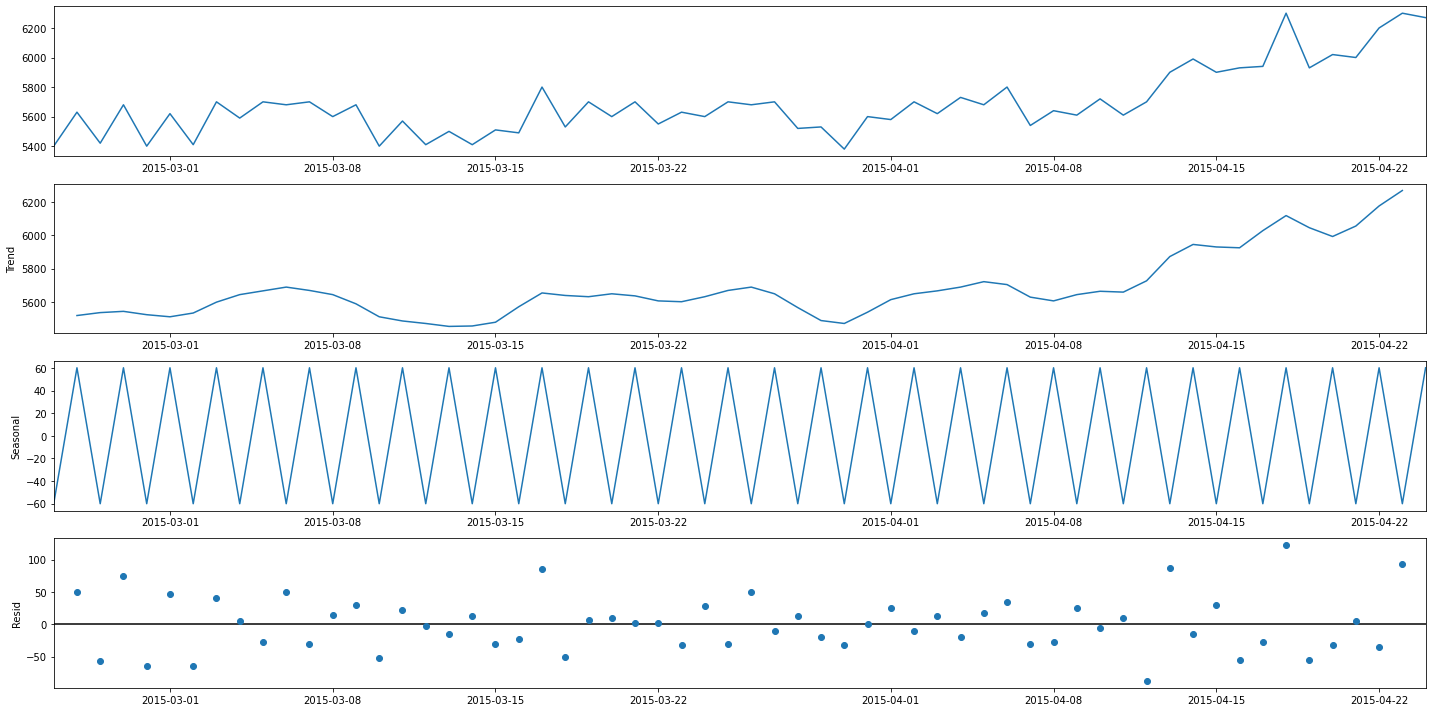

In [7]:
rng = pd.date_range('2015-02-24', periods=60, freq='D')
df = pd.DataFrame({'Val': data }, index=rng)
decompose = sm.tsa.seasonal_decompose(df, model='additive', period=2)
decompose.plot()
pass

## 5) Обоснование выбора тренда

In [8]:
trend = decompose.trend

Графический анализ

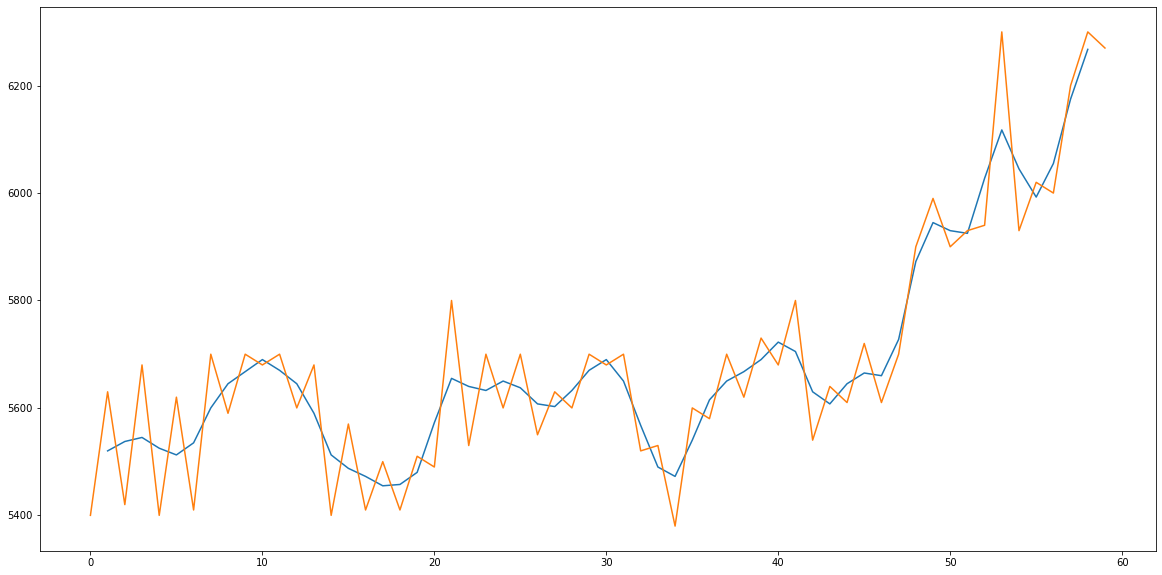

In [9]:
plt.plot(range(60), trend.values)
plt.plot(range(60), data)
pass

Полученный тренд хорошо отражает наши данные визуально

Средняя ошибка аппроксимации мала

In [10]:
abs(((data - trend) / data)).sum() / len(data)

0.010771019507722484

Линейный коэффициент автокорреляции отклонений тоже мал

In [11]:
((data[1:] - data[1:].mean()) * (data[:len(data)-1] - data[:len(data)-1].mean())).sum() / np.sqrt(((data[1:] - data[1:].mean()) ** 2).sum() * ((data[:len(data)-1] - data[:len(data)-1].mean()) ** 2).sum())

0.7209156451673266

Статистическая значимость через F-критерий

Статистика F-теста $ F = \frac{\hat \sigma^2_X}{\hat \sigma_Y} \sim F(m-1, n-1) $

In [12]:
alpha = 0.05
F = trend.var() / data.var()
df1 = len(trend) - 1; df2 = len(data) - 1
p_value = stats.f.cdf(F, df1, df2)
print(p_value)
if alpha < p_value:
    print('accept')
else:
    print('reject')

0.1326407900538642
accept


Статистическая значимость через t-критерий

Статистика t-теста $t = \frac{x_1 - x_2}{ \sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}$

In [13]:
_, p_value = stats.ttest_ind(trend.dropna(), data, equal_var=True) 
print(p_value)
if alpha < p_value:
    print('accept')
else:
    print('reject')

0.8721081100731097
accept


F-критерий и t-критерий также подтверждают нашу гипотезу (не отвергаются гипотезы о равенстве дисперсий и мат. ожиданий)

## 6) Оценка качества модели

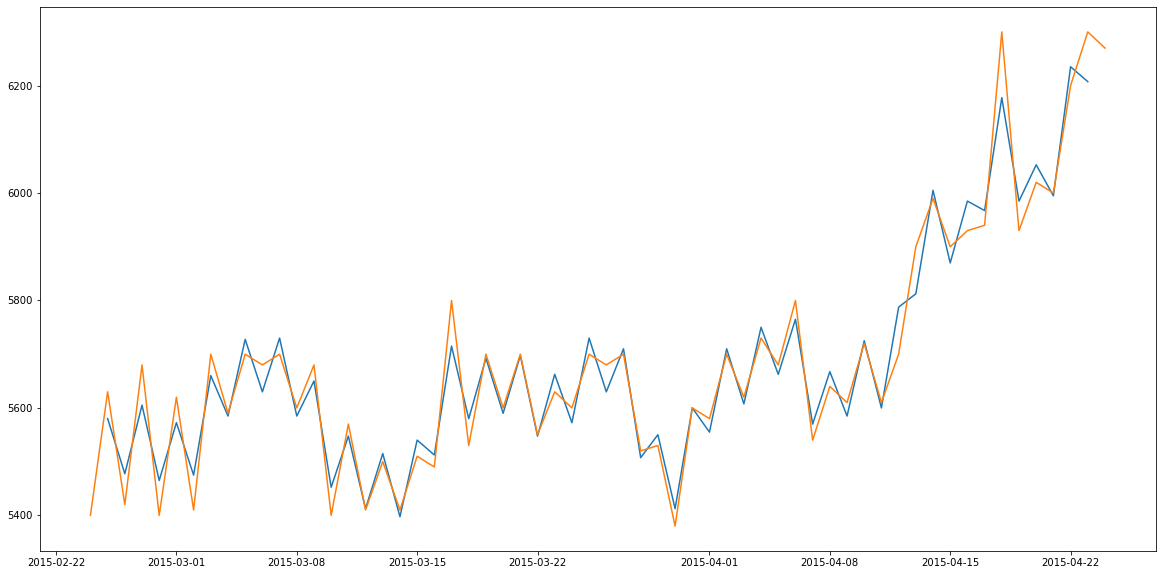

In [14]:
plt.plot(df.index, trend + decompose.seasonal, df.index, df.values)
pass

Средняя абсолютная ошибка состовляет 4% дисперсии, то есть модель объясняет 96% данных

In [15]:
mae = ((data - (trend + decompose.seasonal)) ** 2).mean()
mae, mae / data.var()

(1814.6477407847801, 0.037312604654786884)

# 7) Построение прогноза на 3 периода в перед, оценка ошибки прогноза, построение доверительного интервала прогноза 

Построение прогноза

$ S_t $ - сезонная компонента

$ A_t = T_t + R_t $ - сезонно скорректированная компонента

Чтобы спрогнозировать разложенный временной ряд, мы по отдельности прогнозируем сезонную составляющую $ S_t $ и сезонно скорректированную составляющую $ A_t $. Сезонную составляющую $ S $ спрогнозируем, используя значения за более ранний период. Сезонно скорректированные значения $ A $ прогнозируются с использованием последнего тренда и последних значений остатка, которые мы видели в данном временном ряду.

In [16]:
df_reconstructed = pd.concat(
    [decompose.seasonal, 
     decompose.trend, 
     decompose.resid, 
     decompose.trend + decompose.resid, 
     decompose.observed], axis=1)

df_reconstructed.columns = ['seasonal', 'trend', 'remainders', 'seasonal_adj', 'actual_values']
df_reconstructed.dropna(inplace=True)

df_forecast = df_reconstructed.iloc[-3:,:]
df_forecast = df_forecast.set_index(df_forecast.index.shift(3))
df_forecast = df_forecast.drop('actual_values', axis=1)
df_forecast[['trend', 'remainders', 'seasonal_adj']] = np.nan

df_forecast['trend'] = df_reconstructed.loc[df_reconstructed.index[-1], 'trend']
df_forecast['remainders'] = df_reconstructed.loc[df_reconstructed.index[-1], 'remainders']
df_forecast['seasonal_adj'] = df_forecast['trend'] + df_forecast['remainders']
df_forecast['forecast'] = df_forecast['seasonal_adj'] + df_forecast['seasonal']
df_forecast

,seasonal,trend,remainders,seasonal_adj,forecast
2015-04-24,-60.086207,6267.5,92.586207,6360.086207,6300.000000
2015-04-25,60.086207,6267.5,92.586207,6360.086207,6420.172414
2015-04-26,-60.086207,6267.5,92.586207,6360.086207,6300.000000


Грифик прогноза

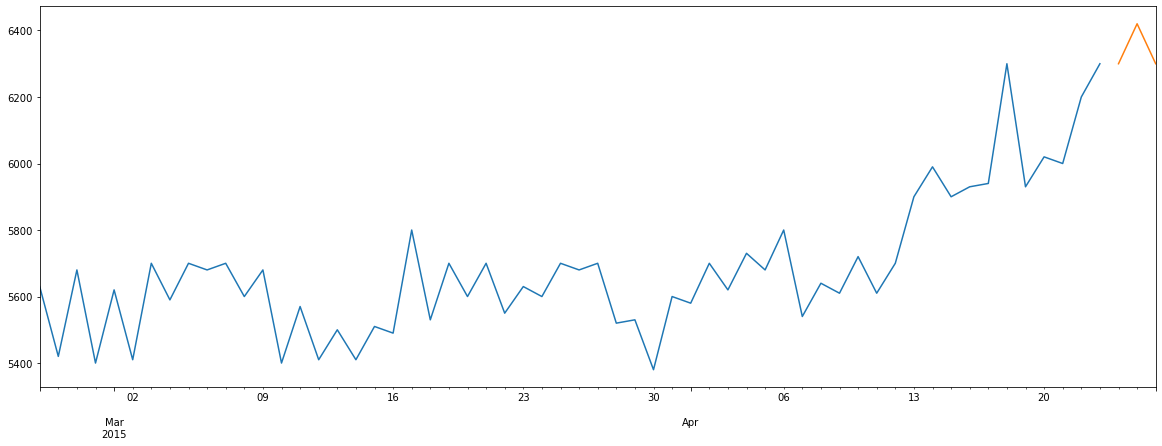

In [17]:
plt.rcParams.update({'figure.figsize': (20,7)})
df_reconstructed['actual_values'].plot()
df_forecast['forecast'].plot()
plt.show()

Построение доверительного интервала прогноза для уровня значимости $ \alpha = 0,05$

Интервал прогнозирования дает интервал, в котором мы ожидаем, что $ y_t $ будет находиться с указанной вероятностью. \ 
Если ошибки прогноза распределены нормально, то 95% интервал прогнозирования вычисляется по формуле

$ y_{T+h|T} \pm 1.96 * \sigma_h $

In [18]:
residuals = df_reconstructed['actual_values'] - (df_reconstructed['seasonal'] + df_reconstructed['trend'])
resid_std = residuals.std()
resid_std

42.955857419336525

In [19]:
df_forecast['h'] = range(1, 4)
df_forecast['std_h'] = resid_std * np.sqrt(df_forecast['h'])

df_forecast['lower_adj'] = (df_forecast['seasonal_adj'] - 1.96 * df_forecast['std_h'])
df_forecast['upper_adj'] = (df_forecast['seasonal_adj'] + 1.96 * df_forecast['std_h'])
df_forecast['lower'] = df_forecast['lower_adj'] + df_forecast['seasonal']
df_forecast['upper'] = df_forecast['upper_adj'] + df_forecast['seasonal']
df_forecast[['h', 'std_h', 'lower', 'upper']]

,h,std_h,lower,upper
2015-04-24,1,42.955857,6215.806519,6384.193481
2015-04-25,2,60.748756,6301.104852,6539.239976
2015-04-26,3,74.401728,6154.172614,6445.827386


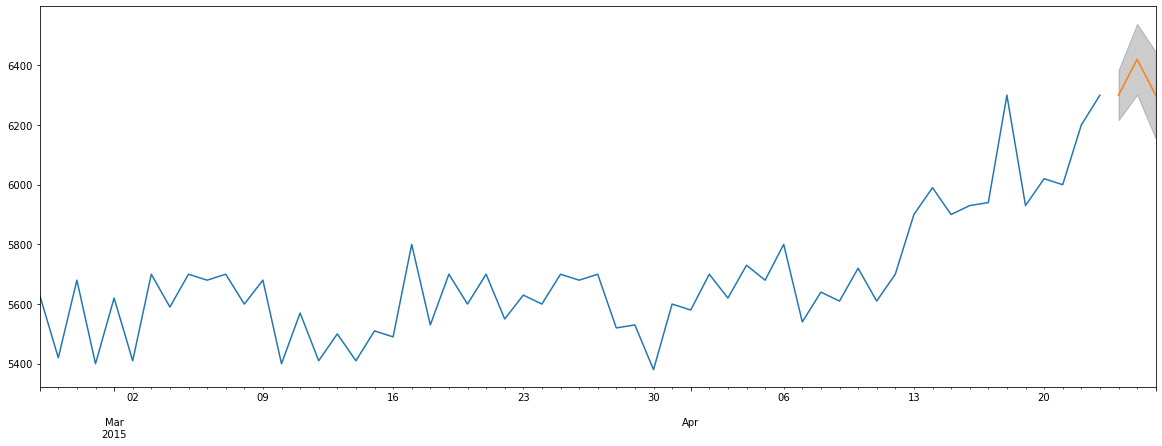

In [20]:
df_reconstructed['actual_values'].plot()
df_forecast['forecast'].plot()
plt.fill_between(df_forecast.index, df_forecast['lower'], df_forecast['upper'], color='k', alpha=.2)
plt.show()

## 8) Построение модели ARIMA(p,q,0)

Проверим степень интеграции

In [21]:
adfuller(data)

(2.5564427308401494,
 0.9990658199020468,
 7,
 52,
 {'1%': -3.562878534649522,
  '5%': -2.918973284023669,
  '10%': -2.597393446745562},
 580.9209964354222)

Cтатистика > 1, ряд нестационарный, поэтому продифференцируем его

In [22]:
diff1 = df-df.shift(1)
diff1.dropna(inplace=True)
adfuller(diff1)

(-2.682473078430328,
 0.0771206077010835,
 7,
 51,
 {'1%': -3.5656240522121956,
  '5%': -2.920142229157715,
  '10%': -2.598014675124952},
 575.0716932757292)

p-value > 5%, поэтому продифференцируем еще раз

(-4.227869113804483,
 0.0005908696698629722,
 10,
 47,
 {'1%': -3.5778480370438146,
  '5%': -2.925338105429433,
  '10%': -2.6007735310095064},
 566.2305150188188)

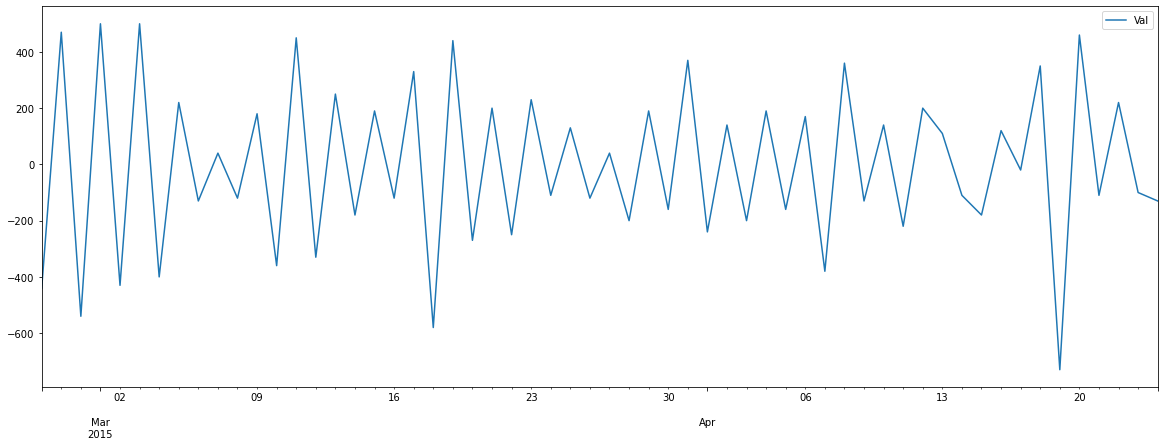

In [23]:
diff2 = diff1-diff1.shift(1)
diff2.dropna(inplace=True)
diff2.plot()
adfuller(diff2)

Для определения параметров ARIMA построим acf и pacf

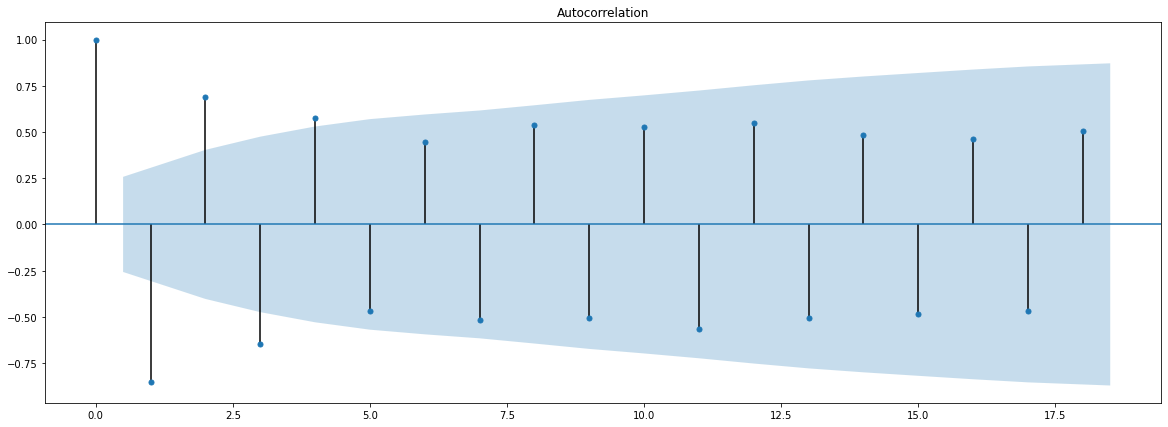

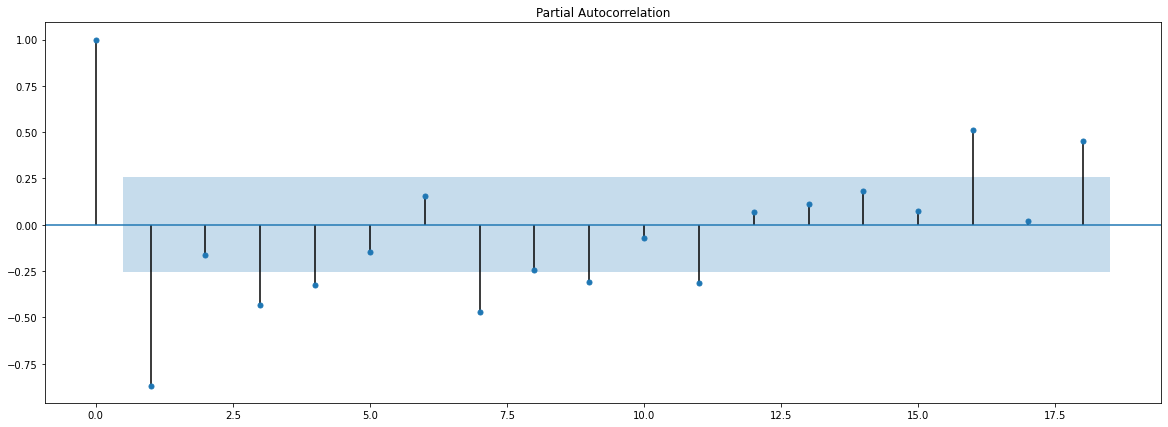

In [24]:
plot_acf(diff2)
plot_pacf(diff2)
pass

## 9) BIC (критерий Шварца), критерий Акаике AIC

Посмотрим на критерий BIC с различными параметрами

(1, 0, 2)


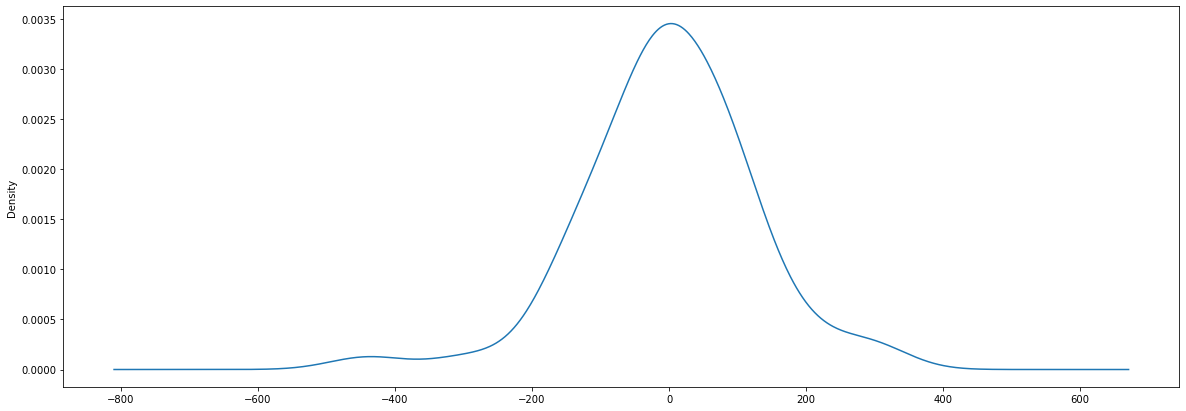

In [25]:
p = d = q = range(0,3)
pdq = list(itertools.product(p,d,q))
combs = {}
bics = []

for combination in pdq[1:]:
    try:
        model = SARIMAX(diff2, order=combination, seasonal=False)
        model = model.fit()
        combs.update({model.bic : combination})
        bics.append(model.bic)
    except:
        continue

best_bic = min(bics)
print(combs[best_bic])
model = SARIMAX(diff2, order=combs[best_bic], seasonal=False)
model1 = model.fit()
model1.resid.plot(kind='kde')
pass

Ошибка полученной модели

In [26]:
(abs(model1.resid)).sum() / len(data)

86.05446170569108

Посмотрим на критерий AIC с различными параметрами

(2, 0, 2)


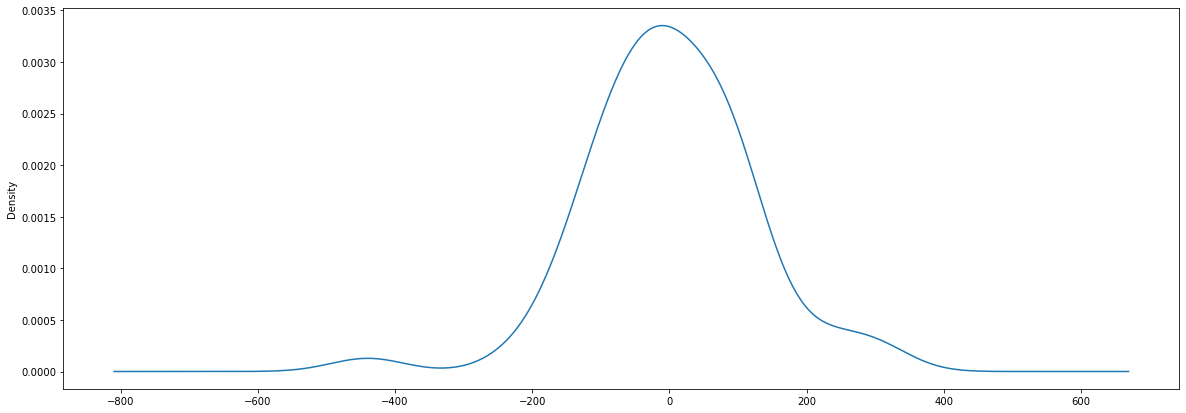

In [27]:
combs = {}
aics = []

for combination in pdq:
    try:
        model = SARIMAX(diff2, order=combination, seasonal=False)
        model = model.fit()
        combs.update({model.aic : combination}) 
        aics.append(model.aic)
    except:
        continue

best_aic = min(aics)
print(combs[best_aic])
model = SARIMAX(diff2, order=combs[best_aic], seasonal=False)
model2 = model.fit()
model2.resid.plot(kind='kde')
pass

Ошибка полученной модели не много меньше, чем у BIC

In [28]:
(abs(model2.resid)).sum() / len(data)

85.96350520050746

Визуально, также заметно модель подобранная с помощью AIC немного лучше описывает данные

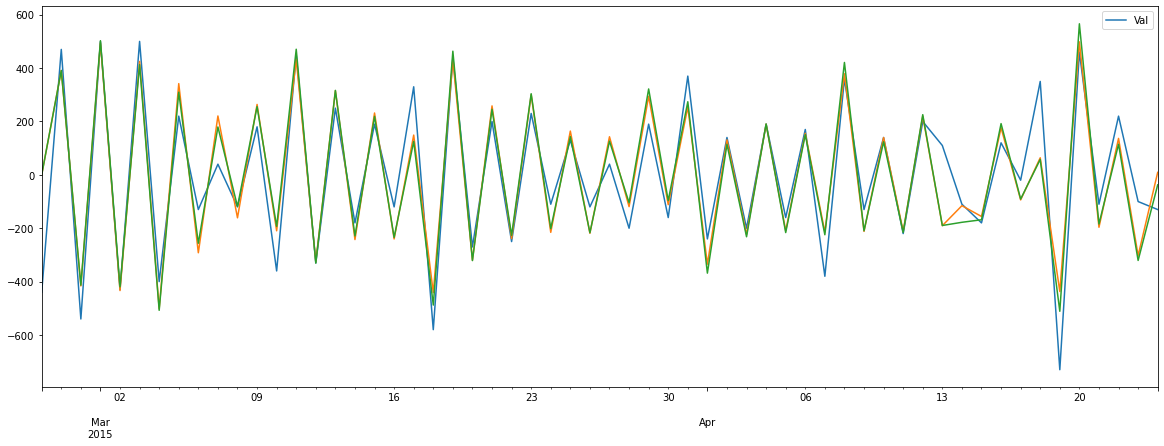

In [29]:
diff2.plot()
model1.fittedvalues.plot()
model2.fittedvalues.plot()
pass

# 2) **Метод главных компонент**

In [30]:
# 2
x1 = [184, 175, 172, 164, 159, 173, 157, 166, 162, 171, 172, 158, 173, 180, 170, 166, 191, 175, 168, 182, 160, 150,
      176, 163, 172, 188, 157, 180, 178, 164, 164, 175, 165, 163, 169, 175, 170, 188, 183, 159]

x2 = [74, 67, 64, 57, 53, 65, 51, 58, 55, 63, 64, 52, 65, 71, 63, 59, 81, 67, 60, 73, 53, 44, 68, 56, 64, 78, 51, 71,
      69, 57, 57, 67, 58, 56, 61, 67, 62, 78, 74, 52]

x3 = [286, 269, 262, 247, 238, 265, 234, 250, 244, 260, 262, 236, 266, 279, 260, 251, 300, 270, 254, 282, 239, 219, 271,
      246, 264, 295, 234, 279, 274, 248, 247, 269, 250, 246, 257, 269, 259, 294, 285, 237]

x4 = [91, 105, 120, 97, 83, 117, 134, 106, 72, 95, 121, 70, 76, 124, 148, 97, 89, 128, 114, 103, 113, 77, 99, 111, 131,
      85, 81, 80, 96, 110, 103, 112, 73, 108, 86, 128, 64, 107, 116, 91]

x5 = [166, 172, 184, 154, 135, 181, 185, 164, 128, 157, 184, 122, 141, 195, 211, 155, 169, 195, 174, 176, 166, 122, 167,
      167, 195, 163, 132, 152, 165, 167, 160, 179, 131, 164, 147, 195, 126, 185, 190, 143]

In [31]:
tmp = np.array([x1, x2, x3, x4, x5]).T
df = pd.DataFrame(tmp)
df.columns = ['x1', 'x2', 'x3', 'x4', 'x5']

## Построение биплота, парных диаграмм рассеяния, вычисление парных коэффициентов корреляции

Построение биплота

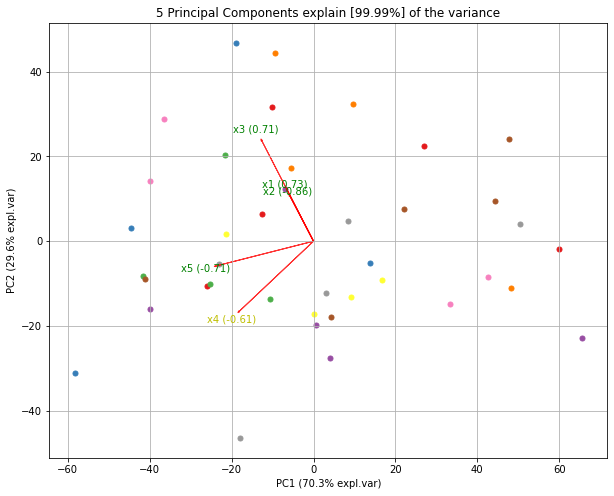

In [32]:
from pca import pca
model = pca(n_components=5)
results = model.fit_transform(df, verbose=0)
fig, ax = model.biplot(n_feat=5, legend=False, label=False)

Построение парных графиков рассеяния

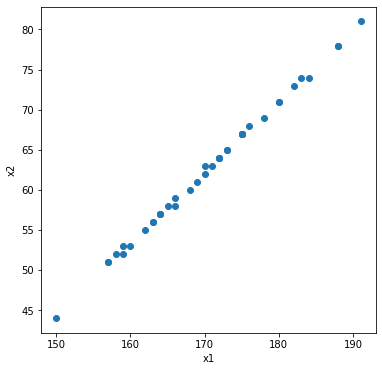

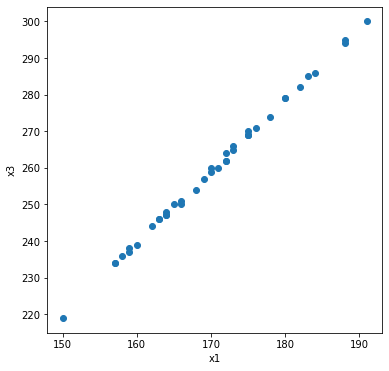

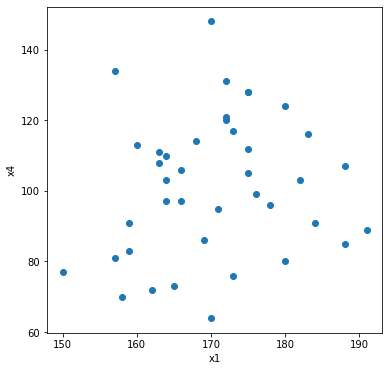

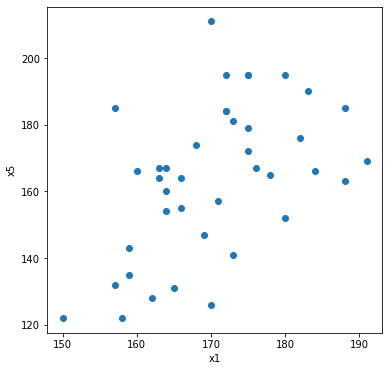

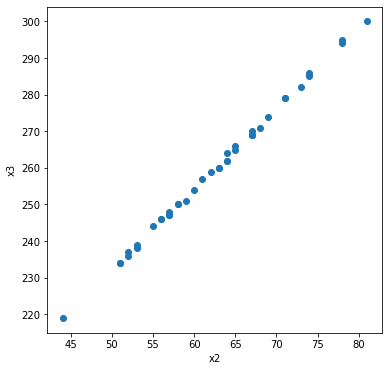

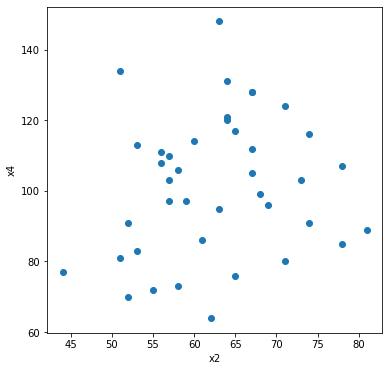

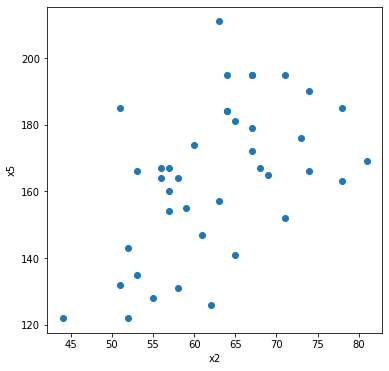

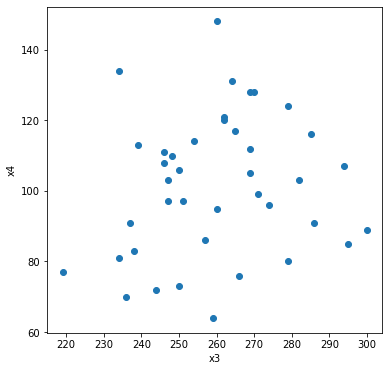

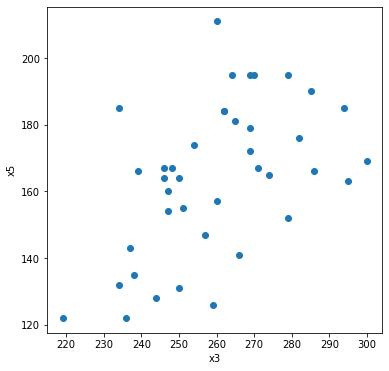

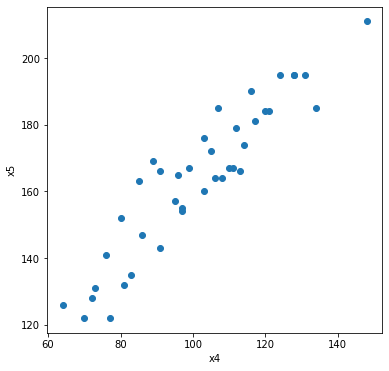

In [33]:
plt.rcParams["figure.figsize"] = (6, 6)
for i in range(len(df.columns)):
    for j in range(i, len(df.columns)):
        if i == j:
            continue
        plt.scatter(df[df.columns[i]], df[df.columns[j]])
        plt.xlabel(df.columns[i])
        plt.ylabel(df.columns[j])
        plt.show()

Вычисление коэффициентов корреляции

In [34]:
np.corrcoef(df.to_numpy().T)
corr = df.corr().to_numpy()
for i in range(len(corr)):
    for j in range(i, len(corr)):
        if i == j:
            continue
        print('Корреляция x%i с x%d =' % (i+1, j+1), corr[i, j])

Корреляция x1 с x2 = 0.9992472480205237
Корреляция x1 с x3 = 0.999386257991568
Корреляция x1 с x4 = 0.1512618698586746
Корреляция x1 с x5 = 0.5038028813751511
Корреляция x2 с x3 = 0.9994211450408517
Корреляция x2 с x4 = 0.16107320775825773
Корреляция x2 с x5 = 0.5123536773948293
Корреляция x3 с x4 = 0.15281961484422305
Корреляция x3 с x5 = 0.5053227603087623
Корреляция x4 с x5 = 0.9298179952604231


## Центрирование и нормирование данных

Центрирование и нормирование данных проводится по формуле \
$ X_{1}=\frac{x_{1 j}-\bar{x}_{1}}{\hat{s}_{1}} ; X_{2}=\frac{x_{2 j}-\bar{x}_{2}}{\hat{s}_{2}} ; \ldots ; X_{m}=\frac{x_{m j}-\bar{x}_{m}}{\hat{s}_{m}} ; j=\overline{1, n} $

In [35]:
df -= df.mean()
df /= df.std()
df

,x1,x2,x3,x4,x5
0,1.417313,1.338800,1.388550,-0.529519,0.083557
1,0.477658,0.514923,0.483263,0.174829,0.347419
2,0.164440,0.161833,0.110498,0.929488,0.875145
3,-0.670809,-0.662044,-0.688284,-0.227655,-0.444169
4,-1.192839,-1.132830,-1.167553,-0.932004,-1.279734
5,0.268846,0.279530,0.270255,0.778557,0.743213
6,-1.401652,-1.368224,-1.380562,1.633837,0.919122
7,-0.461997,-0.544347,-0.528528,0.225140,-0.004398
8,-0.879621,-0.897437,-0.848040,-1.485421,-1.587574
9,0.060033,0.044136,0.003994,-0.328277,-0.312238


## Построение ковариационной матрицы

Ковариационная матрица вычисляется по формуле \
$ \Sigma^{(m)}=\left(\begin{array}{cccc}
\operatorname{cov}\left(X_{1}, X_{1}\right) & \operatorname{cov}\left(X_{1}, X_{2}\right) & \ldots & \operatorname{cov}\left(X_{1}, X_{m}\right) \\
\operatorname{cov}\left(X_{2}, X_{1}\right) & \operatorname{cov}\left(X_{2}, X_{2}\right) & \ldots & \operatorname{cov}\left(X_{2}, X_{m}\right) \\
\ldots & \ldots & \ldots & \ldots \\
\operatorname{cov}\left(X_{m}, X_{1}\right) & \operatorname{cov}\left(X_{m}, X_{2}\right) & \ldots & \operatorname{cov}\left(X_{m}, X_{m}\right)
\end{array}\right) $ \
Можно использовать формулу \
$ \Sigma=\frac{1}{n} X \cdot X^{T} $

In [36]:
covmat = df.cov()
covmat

,x1,x2,x3,x4,x5
x1,1.000000,0.999247,0.999386,0.151262,0.503803
x2,0.999247,1.000000,0.999421,0.161073,0.512354
x3,0.999386,0.999421,1.000000,0.152820,0.505323
x4,0.151262,0.161073,0.152820,1.000000,0.929818
x5,0.503803,0.512354,0.505323,0.929818,1.000000


## Нахождение собственных значений ковариационной матрицы

Для нахожденя собственных значений решим характеристическое уравнение  
$ \left|\sum-\lambda E\right|=0 $

In [37]:
vals, vecs = np.linalg.eig(covmat.to_numpy())
', '.join(map(str, vals))

'3.478122714163776, 1.520431614868579, 0.0007126172051711831, 0.0005501926511067198, 0.00018286111136475038'

## Построение ортогональной матрицы собственных векторов ковариационной матрицы

Находим собственный вектор $ v_{i} $ для каждого собственного значения $ \lambda_{i} $ с помощью системы линейных однородных уравнений
$ \left(\sum-\lambda_{i} E\right) v_{i}=0 $ \
При этом должно соблюдаться условие: \
$ \left|v_{i}\right|=1 $ \
или \
$ \sum_{j=1}^{n} v_{i j}^{2}=v_{i} \cdot v_{i}^{T}=1 $ \
т.е. собственные векторы необходимо нормировать. \
Далее составим ортогональную матрицу собственных векторов \
$ V=\left(\begin{array}{llll}
v_{1} & v_{2} & \ldots & v_{m}
\end{array}\right)=\left(\begin{array}{cccc}
v_{11} & v_{21} & \ldots & v_{m 1} \\
v_{12} & v_{22} & \ldots & v_{m 2} \\
\ldots & \ldots & \ldots & \ldots \\
v_{1 n} & v_{2 n} & \ldots & v_{m n}
\end{array}\right) $

In [38]:
vecs = pd.DataFrame(vecs)
-vecs

,0,1,2,3,4
0,0.507576,0.260843,0.783908,-0.244345,0.010530
1,0.509274,0.253211,-0.591454,-0.570674,-0.032202
2,0.507889,0.259602,-0.186720,0.745610,0.289579
3,0.247304,-0.719544,0.021958,-0.156837,0.629299
4,0.404840,-0.531703,-0.017978,0.184646,-0.720402


## Вычисление последовательной меры информативности главных компонент

Информативность главных компонент вычисляется по формуле \
$ I_{p}=\frac{\lambda_{1}+\ldots+\lambda_{p}}{D x_{1}+\ldots+D x_{m}}, p=1,2, \ldots, m $

In [39]:
vecs = vecs.to_numpy()
narr = df.to_numpy()
I = np.zeros(len(vals))
sum_vals, sum_x = 0, 0
for i in range(len(vals)):
    sum_vals += vals[i]
    sum_x += (narr.std(axis=0) ** 2)[i]
    I[i] = sum_vals / sum_x
pd.DataFrame(I)

,0
0,3.567305
1,2.563361
2,1.709151
3,1.282004
4,1.025641


## Вывод о целесообразном уровне снижения размерности

Больше всего информации несут первые две компонеты. При этом суммарно они несут более 75 % информации. Остальные компоненты несут небольшое количество информации, и их можно опустить. Таким образом, размерность можно снизить до двух компонент.

## Вычисление новых признаков в пространстве двух первых глывных компонент

Новые признаки вычисляются по формуле \
$ Z=L^{T} X $ \
где \
$ \begin{gathered}
z_{i}=v_{i} \cdot X \\
z_{i}=v_{i}^{T} X=v_{i 1} X_{1}+v_{i 2} X_{2}+\ldots+v_{i m} X_{m} ; i=1, \ldots, k
\end{gathered} $

In [40]:
v = -vecs[:, [0, 2]]
Xnew = np.dot(df.to_numpy(), v)
pd.DataFrame(Xnew)

,0,1
0,2.009314,0.046806
1,0.934014,-0.022755
2,0.806164,0.017233
3,-1.263338,-0.002782
4,-2.523942,-0.044513
5,0.909499,-0.001306
6,-1.333267,-0.012395
7,-0.726256,0.063502
8,-2.344291,-0.004480
9,-0.152613,0.018615


## График признаков в пространстве двух первых главных компонент

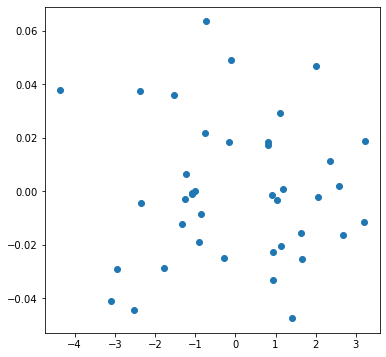

In [41]:
plt.scatter(Xnew[:, 0], Xnew[:, 1])
plt.show()

# **3) Кластерный анализ**

In [42]:
# 3
x1 = [55, 100, 93, 20, 20, 72, 85, 65, 67, 73, 88, 83, 21, 98, 99, 89, 84, 61, 98, 46]
x2 = [3.9, 2.6, 5.3, 4.1, 3.7, 3.6, 6.9, 3, 3.5, 1.7, 6.8, 1, 3.8, 5, 3.3, 0.4, 2.2, 4.2, 3.1, 4.1]
x3 = [30, 47, 37, 12.4, 4.3, 28, 48, 18, 39, 40, 35, 24, 36, 38, 31, 26, 27, 19.2, 44, 23.5]
x4 = [5, 8.2, 12, 7.9, 6.5, 5.4, 11, 9.5, 8.8, 10.9, 8.1, 8.8, 9.8, 10.3, 9.6, 8.95, 9.6, 7.2, 7.4, 6.7]
x5 = [28, 121, 146, 52, 72, 38, 83, 92, 91, 73, 138, 99, 55, 89, 87, 103, 169, 10, 123, 20]
x6 = [124, 87, 74, 141, 134, 120, 72, 156, 91, 106, 73, 108, 140, 77, 102, 72, 118, 191, 77, 134]

labels = ['Россия', 'Австралия', 'Австрия', 'Азербайджан', 'Армения', 'Беларусь', 'Бельгия', 'Болгария',
          'Великобритания', 'Венгрия', 'Германия', 'Греция', 'Грузия', 'Дания', 'Ирландия', 'Испания', 'Италия',
          'Казахстан', 'Канада', 'Киргизия']

headers = ['Мясо', 'Масло', 'Сахар', 'Алкоголь', 'Фрукты', 'Хлебопродукты']

data = list(zip(x1, x2, x3, x4, x5, x6))

In [43]:
signs = list(range(1, 21))
signs_table = list(zip(signs, labels))
d = pd.DataFrame(signs_table)
print(d.to_string(index=False, header=False))

  1          Россия
  2       Австралия
  3         Австрия
  4     Азербайджан
  5         Армения
  6        Беларусь
  7         Бельгия
  8        Болгария
  9  Великобритания
 10         Венгрия
 11        Германия
 12          Греция
 13          Грузия
 14           Дания
 15        Ирландия
 16         Испания
 17          Италия
 18       Казахстан
 19          Канада
 20        Киргизия


## 1) Иерархическая кластеризация методом "ближнего соседа" с использованием евклидова растояния

При методе ближнего соседа расстояние между двумя кластерами полагается равным минимальному расстоянию между двумя элементами из разных кластеров: $ \min \{d(a, b): a \in A, b \in B\} $, где $ d(a, b) $ - расстояние между элементами $ a $ и $ b $, принадлежащими кластерам $ A $ и $ B $

Для вычисления расстояния между двумя элементами будем использовать евклидово расстояние. Для точек $ p=\left(p_{1}, \ldots, p_{n}\right) $ и $  q=\left(q_{1}, \ldots, q_{n}\right) $ евклидово расстояние определяется следующим образом: $ d(p, q)=\sqrt{\left(p_{1}-q_{1}\right)^{2}+\left(p_{2}-q_{2}\right)^{2}+\cdots+\left(p_{n}-q_{n}\right)^{2}}=\sqrt{\sum_{k=1}^{n}\left(p_{k}-q_{k}\right)^{2}} $

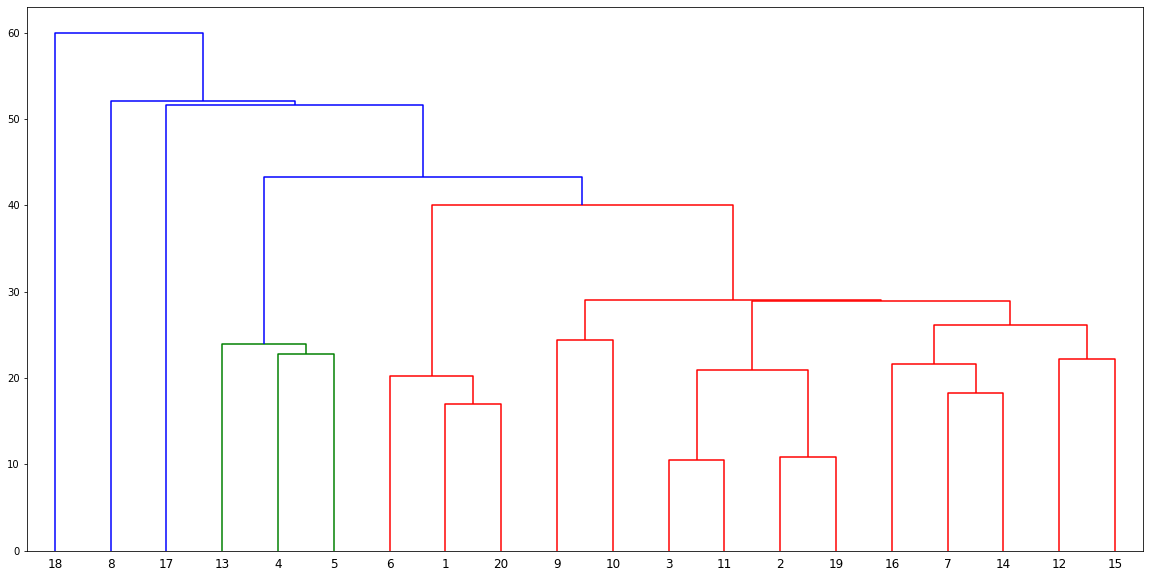

In [44]:
plt.rcParams["figure.figsize"] = (20, 10)
plt.figure()
linked = linkage(data, method='single', metric='euclidean')
dendrogram(linked, orientation='top', labels=signs, distance_sort='descending', show_leaf_counts=True)
plt.show()

## 2) Иерархическая кластеризация методом "дальнего соседа" с использованием евклидова растояния

При методе дальнего соседа, расстояние между двумя кластерами между двумя кластерами полагается равным максимальному расстоянию между двумя элементами из разных кластеров: $ \max \{d(a, b): a \in A, b \in B\} $. Для вычисления расстояния между элементами будем так же использовать евклидово расстояние.

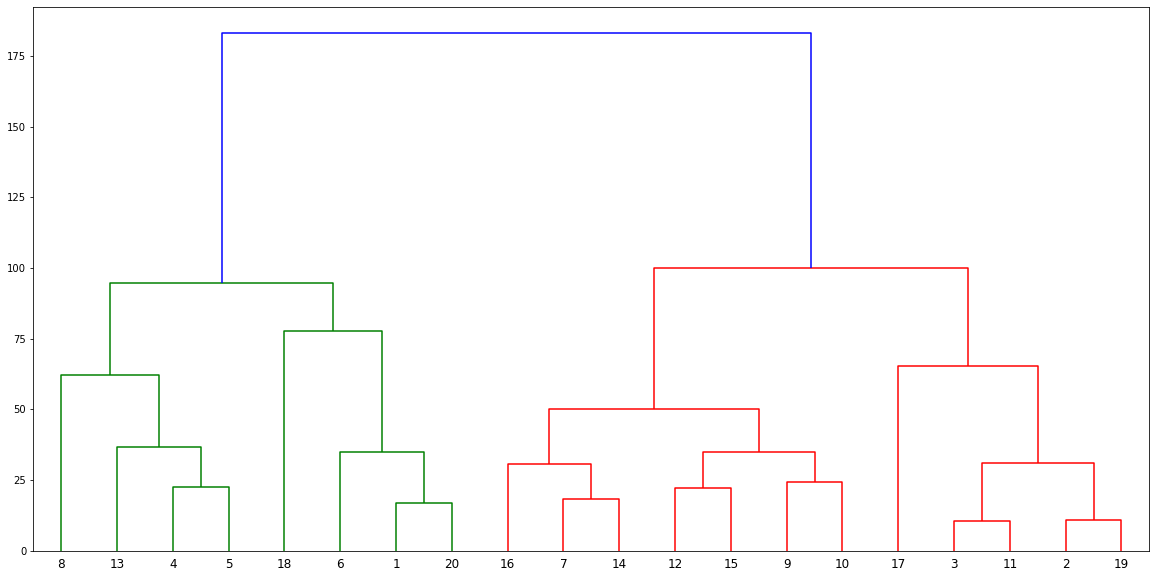

In [45]:
plt.figure()
linked = linkage(data, method='complete', metric='euclidean')
dendrogram(linked, orientation='top', labels=signs, distance_sort='descending', show_leaf_counts=True)
plt.show()

## 2) Иерархическая кластеризация методом "ближнего соседа" с использованием расстояния Махаланобиса 

Снова применим метод ближнего соседа, но теперь для вычисления расстояния между элементами воспользуемся расстоянием Махаланобиса. \
Расстояние Махаланобиса - мера расстояния между векторами случайных величин, обобщающая понятие евклидова расстояния. расстояние Махаланобиса от многомерного вектора $ x=(x_{1},x_{2},x_{3},\dots ,x_{N})^{T} $ до множества со средним значением $ \mu =(\mu _{1},\mu _{2},\mu _{3},\dots ,\mu _{N})^{T} $ и матрицей ковариации $ S $ определяется следующим образом: \
$ D_{M}(x)={\sqrt {(x-\mu )^{T}S^{-1}(x-\mu )}} $

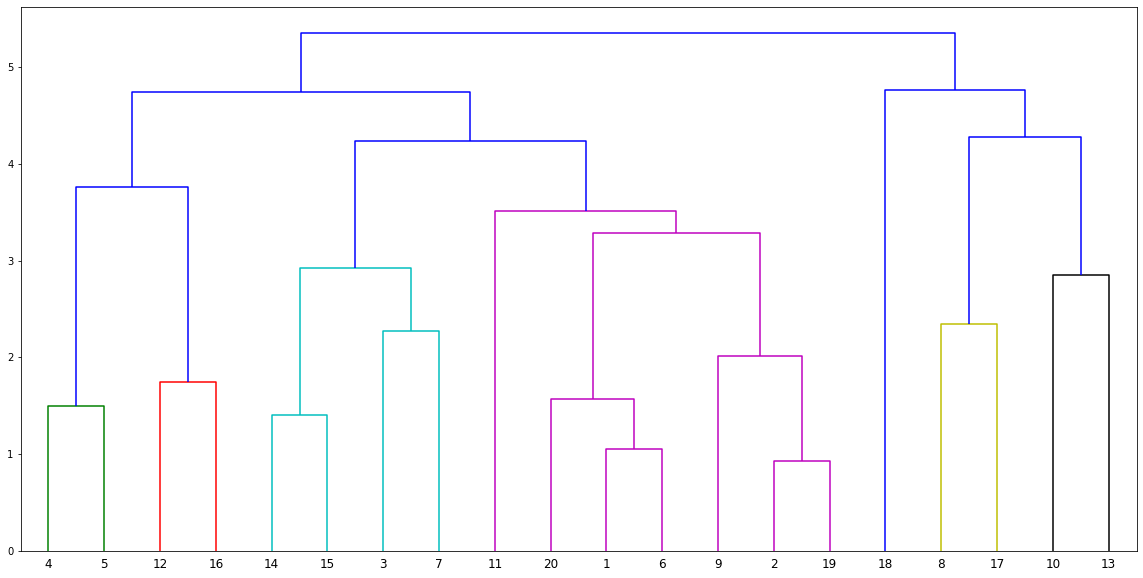

In [46]:
plt.figure()
linked = linkage(data, method='complete', metric='mahalanobis')
dendrogram(linked, orientation='top', labels=signs, distance_sort='descending', show_leaf_counts=True)
plt.show()